# Data analysis notebook to produce all graphs

## Author

Bradley Kelman

## Imports and dask

In [5]:
import math

# import holoviews as hv
import os
import re
from itertools import chain

import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn import preprocessing

# from tkinter import Tcl

## All functions required

In [6]:
def open_data_in_order(correct_order_list):
    dataset_lst = []
    for i in range(len(correct_order_list)):
        tmp = xr.open_dataset(f"{correct_order_list[i]}")
        dataset_lst.append(tmp)
    return dataset_lst

In [7]:
def open_multiple_txt_files(fileList):
    profile_list = []
    for files in fileList:
        profile_list.append(np.loadtxt(files))
    return profile_list

In [8]:
def divide_two_lists(numerator, denom):
    res = [i / j for i, j in zip(numerator, denom)]
    return res

In [9]:
def offset_lists(list_len, offset, num_of_lists):
    list_of_lists = [[0] * list_len]
    for i in range(num_of_lists - 1):
        tmp_lst = [(i + 1) * offset] * list_len
        list_of_lists.append(tmp_lst)
    return list_of_lists

In [10]:
def get_fileList(directorypath):
    fileList = []
    count = 0

    for dirname, dirnames, filenames in os.walk(directorypath):
        for filename in filenames:
            if filename.endswith(".nc"):
                fileList.append(f"{dirname}/{filename}")
                count = count + 1
    return Tcl().call("lsort", "-dict", fileList)

In [11]:
def residual_profiles_and_sum(
    ds, target_profiles, full_EPER=False, calibration_mode=True, batch_number="not_8"
):

    resid_lst = []
    resid_profiles = []
    square_resid_profiles = []
    sum_square_resid_list = []

    if calibration_mode == True:
        best_data = find_best(ds)
        EPER_tail = len(ds["y"])
        best_island_index = int(best_data[1] - 1)
        for i in range(len(target_profiles)):
            if batch_number == 8:
                sim = (
                    ds["simulated_pixel"][best_island_index]
                    .sel(processor=i)[0]
                    .values.flatten()
                )  # batches 0 to 7 have id_processor - batch_8 and processor
            else:
                sim = (
                    ds["simulated_pixel"][best_island_index]
                    .sel(id_processor=i)[0]
                    .values.flatten()
                )  # batches 0 to 7 have id_processor - batch_8 and processor
            if EPER_tail == 236:
                start_EPER = 2064
            elif EPER_tail == 235:
                start_EPER = 2065
            elif EPER_tail == 234:
                start_EPER = 2066
            elif EPER_tail == 233:
                start_EPER = 2067
            else:
                start_EPER = 2065
            target = target_profiles[i][start_EPER : start_EPER + EPER_tail].flatten()
            # target = ds['target'].sel(id_processor=i).values #all_data_in_correct_order[1]['target'] changed to ds
            # resid = abs(sim - target)
            # resid = abs(sim - target)
            if len(target) == 235 or full_EPER == True:
                resid = (
                    sim - target
                )  # the brackets are needed in target for the EPER tails to ensure the sim and target are of the same length - the last element in the target seems to be nan
                square_resid = (resid) ** 2
                sum_resid = np.sum(resid)
                sum_square_resid = np.sum(square_resid)
                square_resid_profiles.append(square_resid)

            else:
                resid = abs(
                    sim[:-1] - target[:-1]
                )  # the brackets are needed in target for the EPER tails to ensure the sim and target are of the same length - the last element in the target seems to be nan
                square_resid = (resid) ** 2
                sum_resid = np.sum(resid)
                sum_square_resid = np.sum(square_resid)
                square_resid_profiles.append(square_resid)

            resid_profiles.append(resid)
            resid_lst.append(sum_resid)
            sum_square_resid_list.append(sum_square_resid)

        return resid_profiles, resid_lst, square_resid_profiles, sum_square_resid_list

    else:
        for i in range(len(target_profiles)):
            sim_tmp = ds["pixel"].sel(filename_id=i).squeeze().values
            sim = sim_tmp[2065:]
            target = target_profiles[i][2065:]

            if len(target) == 235 or full_EPER == True:
                resid = (
                    sim - target
                )  # the brackets are needed in target for the EPER tails to ensure the sim and target are of the same length - the last element in the target seems to be nan
                square_resid = (resid) ** 2
                sum_resid = np.sum(resid)
                sum_square_resid = np.sum(square_resid)
                square_resid_profiles.append(square_resid)

            else:
                resid = abs(
                    sim[:-1] - target[:-1]
                )  # the brackets are needed in target for the EPER tails to ensure the sim and target are of the same length - the last element in the target seems to be nan
                square_resid = (resid) ** 2
                sum_resid = np.sum(resid)
                sum_square_resid = np.sum(square_resid)
                square_resid_profiles.append(square_resid)

            resid_profiles.append(resid)
            resid_lst.append(sum_resid)
            sum_square_resid_list.append(sum_square_resid)

        return resid_profiles, resid_lst, square_resid_profiles, sum_square_resid_list

In [12]:
def find_best(ds):
    best = (
        ds.champion_parameters.isel(evolution=-1)
        .isel(island=ds.champion_fitness.isel(evolution=-1).argmin())
        .to_dataframe()
    )
    return best, best["island"][0], best["evolution"][0]

In [13]:
def list_addition_and_subtaction(list1, list2):
    list_add = []
    list_sub = []
    for i in range(len(list1)):
        list1_len = int(len(list1[i]))
        tmp1 = abs(list1[i] - list2[i][:list1_len])
        tmp2 = list1[i] + list2[i][:list1_len]
        list_add.append(tmp1)
        list_sub.append(tmp2)
    return list_add, list_sub

In [14]:
def create_row_numbers(number):
    row_numbers = []
    for i in range(number):
        j = i + 2065
        row_numbers.append(int(j))
    return row_numbers


# row_number = create_row_numbers(2300)

In [15]:
def create_row_numbers_2066(number):
    row_numbers = []
    for i in range(number):
        j = i + 2066
        row_numbers.append(int(j))
    return row_numbers


# row_number = create_row_numbers(2300)

In [16]:
def get_average_peak_flat_field_level(profile_list):
    average_peak_signal = []
    for profiles in profile_list:
        average_peak_signal.append(round(np.average(profiles[820:2040])))

    return average_peak_signal

In [17]:
def plot_to_given_pixels(
    EPER_tail, residual_profiles, lists, phone_brightness, savename, b=None
):
    if EPER_tail == 234:
        row_numbers = create_row_numbers_2066(len(residual_profiles[0][:b]))
    else:
        row_numbers = create_row_numbers(len(residual_profiles[0][:b]))

    final_list = []
    plt.close()
    fig, ax = plt.subplots()
    # num_run_max = np.max(lists)
    if np.max(lists) == 450:
        number_of_runs = [
            0,
            50,
            100,
            150,
            200,
            250,
            300,
            350,
            400,
            450,
            500,
            550,
            600,
            650,
            700,
            750,
            800,
        ]
    else:
        number_of_runs = [
            0,
            5,
            10,
            15,
            20,
            25,
            30,
            35,
            40,
            45,
            50,
            55,
            60,
        ]  # range(1,11)    # use your actual number_of_runs
    for i in range(len(residual_profiles)):
        tmp = list_addition_and_subtaction(residual_profiles[i][:b], lists[i])
        final_list.append(tmp[1])
        plt.title(f"{savename[19:]}")
        ax.plot(row_numbers, tmp[1], label=f"{phone_brightness[i]}e", linewidth=1)
        # return row_numbers, tmp[1],residual_profiles[i], lists[i]
        plt.xlabel("EPER row number")
        plt.ylabel("Residuals")
        plt.legend(bbox_to_anchor=[1, 0.8])
        xlim = 2065 + int(len(residual_profiles[0][:b]))
        plt.xlim(2065, xlim)
        ax.set_yticks(number_of_runs, minor=False)
        ax.xaxis.grid(True, which="major")
        ax.yaxis.grid(True, which="major")
        plt.savefig(
            f"Graphs/Residuals/Offset_residuals/{savename}_{EPER_tail}_pixel_plot.png",
            bbox_inches="tight",
            dpi=100,
        )
        # print('-------------')

    plt.close()
    fig, ax = plt.subplots()

    if EPER_tail >= 10:

        if EPER_tail == 234:
            row_numbers = create_row_numbers_2066(10)
        else:
            row_numbers = create_row_numbers(10)

        final_list = []
        for i in range(len(residual_profiles)):
            tmp = list_addition_and_subtaction(residual_profiles[i][:b], lists[i])
            final_list.append(tmp[1])
            plt.title(f"{savename[19:]}")
            ax.plot(
                row_numbers, tmp[1][:10], label=f"{phone_brightness[i]}e", linewidth=1
            )
            # return row_numbers, tmp[1],residual_profiles[i], lists[i]
            plt.xlabel("EPER row number")
            plt.ylabel("Residuals")
            plt.legend(bbox_to_anchor=[1, 0.8])
            # xlim = 2115#2065+int(len(residual_profiles[0][:b]))
            # plt.xlim(2065,xlim)
            ax.set_yticks(number_of_runs, minor=False)
            ax.xaxis.grid(True, which="major")
            ax.yaxis.grid(True, which="major")
            plt.savefig(
                f"Graphs/Residuals/Offset_residuals/{savename}_{EPER_tail}_pixel_plot_first_10_pix.png",
                bbox_inches="tight",
                dpi=100,
            )
            # print('-------------')

    plt.close()

    if EPER_tail >= 50:
        fig, ax = plt.subplots()
        if EPER_tail == 234:
            row_numbers = create_row_numbers_2066(50)
        else:
            row_numbers = create_row_numbers(50)
        final_list = []
        for i in range(len(residual_profiles)):
            tmp = list_addition_and_subtaction(residual_profiles[i][:b], lists[i])
            final_list.append(tmp[1])
            plt.title(f"{savename[19:]}")
            ax.plot(
                row_numbers, tmp[1][:50], label=f"{phone_brightness[i]}e", linewidth=1
            )
            # return row_numbers, tmp[1],residual_profiles[i], lists[i]
            plt.xlabel("EPER row number")
            plt.ylabel("Residuals")
            plt.legend(bbox_to_anchor=[1, 0.8])
            # xlim = 2115#2065+int(len(residual_profiles[0][:b]))
            # plt.xlim(2065,xlim)
            ax.set_yticks(number_of_runs, minor=False)
            ax.xaxis.grid(True, which="major")
            ax.yaxis.grid(True, which="major")
            plt.savefig(
                f"Graphs/Residuals/Offset_residuals/{savename}_{EPER_tail}_pixel_plot_first_50_pix.png",
                bbox_inches="tight",
                dpi=100,
            )
            # print('-------------')
    else:
        pass

In [18]:
def plot_residuals_with_offsets(ds, target_profiles, phone_brightness, savename):
    if len(ds.attrs) < 3:
        residuals = residual_profiles_and_sum(ds, target_profiles, True, False)
        EPER_tail1 = 235
        EPER_tail2 = int(savename[31:-21])
        residual_profiles = residuals[0]

        lists = offset_lists(
            EPER_tail1, 5, len(phone_brightness)
        )  # for the other data the legnth needs to be changed to 234 to work properly
        plot_to_given_pixels(
            EPER_tail1, residual_profiles, lists, phone_brightness, savename
        )

        lists = offset_lists(EPER_tail2, 5, len(phone_brightness))
        b = int(len(lists[0]))
        plot_to_given_pixels(
            EPER_tail2, residual_profiles, lists, phone_brightness, savename, b
        )

    else:
        EPER_tail = len(ds["y"])
        # return EPER_tail

        if EPER_tail < 230:
            full_EPER_tail = False
        else:
            full_EPER_tail = True

        residuals = residual_profiles_and_sum(ds, target_profiles, full_EPER_tail, True)
        # return residuals[0]
        offset = (math.ceil(np.max(residuals[0]) / 10.0)) * 5

        residual_profiles = residuals[0]
        # if np.max(residuals[0]) > 5:
        lists = offset_lists(EPER_tail, offset, len(phone_brightness))
        test = plot_to_given_pixels(
            EPER_tail, residual_profiles, lists, phone_brightness, savename
        )

        # else:
        # offset = (math.ceil(np.max(residuals[0]) / 10.0)) * 5
        # lists = offset_lists(EPER_tail,5,10)
        # return EPER_tail, residual_profiles,lists,phone_brightness,savename
        # test = plot_to_given_pixels(EPER_tail,residual_profiles,lists,phone_brightness,savename)
        return EPER_tail, residual_profiles, lists, phone_brightness, savename

In [19]:
def plot_resi_vs_signal_multi_specific_norm(
    avg_sig_vals,
    ds_list,
    num_list,
    title,
    savename,
    target_profiles,
    legend=None,
    xlog_scale=False,
    ylog_scale=False,
    markers=False,
):
    # %matplotlib ipympl
    plt.close()

    # best_data_list = []
    residuals = []
    for num in num_list:
        if len(ds_list[num].attrs) < 3:
            residuals.append(
                residual_profiles_and_sum(ds_list[num], target_profiles, True, False)
            )

        else:
            # best_data_list.append(find_best(ds_list[num]))
            residuals.append(
                residual_profiles_and_sum(ds_list[num], target_profiles, True, True)
            )
    residual_profiles = []
    residual_list = []
    for i in range(len(residuals)):
        residual_profiles.append(residuals[i][0])
        residual_list.append(residuals[i][1])
    norm_resid_list = []
    for j in range(len(residual_list)):
        norm_resid_list.append(preprocessing.normalize([residual_list[j]]))
        # norm_resid_list.append(divide_two_lists(residual_list[j],avg_sig_vals))

    plt.grid(visible=True, which="major", color="#300000", linestyle="--")
    plt.xlabel("signal value (e)")
    plt.ylabel("Residuals")
    # plt.ylim(0,1)
    plt.grid(visible=True, which="major", color="#300000", linestyle="--")
    plt.xlabel("signal value (e)")
    plt.ylabel("Normalised residuals")
    plt.title(f"{title}")
    if xlog_scale == True:
        plt.xscale("log")
        savename = f"{savename}_Xlog"
    if ylog_scale == True:
        plt.yscale("log")
        savename = f"{savename}_Ylog"
    if markers == False:
        for i in range(len(norm_resid_list)):
            plt.scatter(
                avg_sig_vals, norm_resid_list[i], label=f"{legend[i]}", marker="x"
            )
    else:
        print(len(norm_resid_list))
        print(len(legend))
        for i in range(len(norm_resid_list)):
            plt.scatter(
                avg_sig_vals,
                norm_resid_list[i],
                label=f"{legend[i]}",
                marker=markers[i],
            )
    # if len(num_list) > 8:
    # plt.legend(title='EPER tail length',bbox_to_anchor=(1,1))
    # else:
    plt.legend()
    plt.savefig(
        f"Graphs/Residuals/residuals_vs_signal/{savename}.png",
        bbox_inches="tight",
        dpi=100,
    )

In [20]:
def create_savename_for_resid_vs_sig(str_list, set_subdir, log=False, extra=""):
    savename_list = []
    for i in range(len(str_list)):
        if log == False:
            savename_list.append(f"G/{set_subdir}/{str_list[i]}_resid_vs_sig{extra}")
        elif log == True:
            savename_list.append(
                f"G/{set_subdir}/{str_list[i]}_resid_vs_sig_LOG{extra}"
            )
    return savename_list

In [21]:
def get_legend_list(set_filenames, run_numbers, legend_splitter=9):
    legend_list = []
    for num in run_numbers:
        if legend_splitter == 9:
            legend_list.append(set_filenames[num].split("_")[legend_splitter])
        elif legend_splitter == 0:
            legend_list.append(set_filenames[num].split("_")[legend_splitter][0:1])

    return legend_list

In [25]:
def get_filenames_from_fileList(fileList):
    filename_list = []
    if len(fileList) = 1:
        return fileList.split('/')[-1].split('.')[0]
    for files in fileList:
        filename_list.append(files.split('/')[-1].split('.')[0])          
    return filename_list        

## Loading lab calibration data

In [113]:
dirpath_1 = "../Results/"
fileList_1 = get_fileList(dirpath_1)
data_1 = open_data_in_order(fileList_1)
filenames_1 = get_filenames_from_fileList(fileList_1)
subdir_1 = "batch_1"

## Obtaining misc data needed

In [21]:
target_list_new_std_dev_all = [
    "../../data/1D/target/r_G1_10.txt",
    "../../data/1D/target/r_G1_20.txt",
    "../../data/1D/target/r_G1_30.txt",
    "../../data/1D/target/r_G1_50.txt",
    "../../data/1D/target/r_G1_60.txt",
    "../../data/1D/target/r_G1_70.txt",
    "../../data/1D/target/r_G1_80.txt",
    "../../data/1D/target/r_G1_90.txt",
    "../../data/1D/target/r_G1_100.txt",
    "../../data/1D/target/r_G1_110.txt",
    "../../data/1D/target/r_G1_120.txt",
]

In [22]:
target_profiles_all = open_multiple_txt_files(target_list_new_std_dev_all)

In [23]:
G0_list_all = [
    "../../data/1D/input/r_G0_10.txt",
    "../../data/1D/input/r_G0_20.txt",
    "../../data/1D/input/r_G0_30.txt",
    "../../data/1D/input/r_G0_50.txt",
    "../../data/1D/input/r_G0_60.txt",
    "../../data/1D/input/r_G0_70.txt",
    "../../data/1D/input/r_G0_80.txt",
    "../../data/1D/input/r_G0_90.txt",
    "../../data/1D/input/r_G0_100.txt",
    "../../data/1D/input/r_G0_110.txt",
    "../../data/1D/input/r_G0_120.txt",
]

In [24]:
G0_old_profiles_all = open_multiple_txt_files(G0_list_all)

In [25]:
phone_brightness_all = get_average_peak_flat_field_level(G0_old_profiles_all)

In [26]:
phone_brightness_all

[11, 22, 26, 62, 105, 143, 199, 271, 388, 509, 666]

## Plotting

### Offset residuals

### New  subplot offset residuals 

##### batch 4

In [94]:
filenames_4

['3Trp_id1_closed_beta_closed_0_wnd_closed_fef_235_EPER_all_signals_minus_40',
 '3Trp_id2_open_beta_closed_0_wnd_closed_fef_235_EPER_all_signals_minus_40',
 '3Trp_id3_open_beta_open_neg_wnd_closed_fef_235_EPER_all_signals_minus_40',
 '3Trp_id4_closed_beta_open_neg_wnd_closed_fef_235_EPER_all_signals_minus_40',
 '3Trp_id5_closed_beta_closed_0_wnd_open_fef_235_EPER_all_signals_minus_40',
 '3Trp_id6_open_beta_closed_0_wnd_open_fef_235_EPER_all_signals_minus_40',
 '3Trp_id7_open_beta_open_neg_wnd_open_fef_235_EPER_all_signals_minus_40',
 '3Trp_id8_closed_beta_open_neg_wnd_open_fef_235_EPER_all_signals_minus_40']

In [152]:
residual_lists = []
offset_list_of_lists = []
residual_profiles_lists = []
plotting_list_of_lists = []
plotting_offset_values_lists = []
plotting_offset_values = []
filenames_1_list = []

for i in range(len(data_varying_traps)):
    residuals = residual_profiles_and_sum(
        data_varying_traps[i], target_profiles_all, True, True
    )
    offset = (math.ceil(np.max(residuals[0]) / 10.0)) * 5
    residual_profiles = residuals[0]
    filenames_1_list.append(filenames_1[i])
    residual_lists.append(residuals)
    offset_list_of_lists.append(offset)
    residual_profiles_lists.append(residual_profiles)

    plotting_list = offset_lists(235, offset, len(phone_brightness_all))
    plotting_list_of_lists.append(plotting_list)

    tmp = list_addition_and_subtaction(residual_profiles, plotting_list)

    plotting_offset_values.append(tmp)

In [ ]:
scale_factor = 1.5
fig, ax = plt.subplots(
    2, 2, figsize=(scale_factor * 8, scale_factor * 6), sharex=True, sharey=True
)
# fig, ax = plt.subplots(4,2, figsize=(scale_factor*8,scale_factor*12),sharex=True,sharey=True)

# fig, ax = plt.subplots(2,2, figsize=(scale_factor*16,scale_factor*18),sharex=True,sharey=True)
plt.tight_layout()
y_major_locator = MultipleLocator(5)
x_major_locator = MultipleLocator(50)

ax[0, 0].plot(
    plotting_offset_values[0][1][10][:50],
    label=f"{phone_brightness_all[10]}",
    linestyle="--",
)
ax[0, 0].plot(plotting_offset_values[0][1][9][:50], label=f"{phone_brightness_all[9]}")
ax[0, 0].plot(plotting_offset_values[0][1][8][:50], label=f"{phone_brightness_all[8]}")
ax[0, 0].plot(plotting_offset_values[0][1][7][:50], label=f"{phone_brightness_all[7]}")
ax[0, 0].plot(plotting_offset_values[0][1][6][:50], label=f"{phone_brightness_all[6]}")
ax[0, 0].plot(plotting_offset_values[0][1][5][:50], label=f"{phone_brightness_all[5]}")
ax[0, 0].plot(plotting_offset_values[0][1][4][:50], label=f"{phone_brightness_all[4]}")
ax[0, 0].plot(plotting_offset_values[0][1][3][:50], label=f"{phone_brightness_all[3]}")
ax[0, 0].plot(plotting_offset_values[0][1][2][:50], label=f"{phone_brightness_all[2]}")
ax[0, 0].plot(plotting_offset_values[0][1][1][:50], label=f"{phone_brightness_all[1]}")
ax[0, 0].plot(plotting_offset_values[0][1][0][:50], label=f"{phone_brightness_all[0]}")
ax[0, 0].xaxis.set_minor_locator(x_major_locator)
ax[0, 0].yaxis.set_minor_locator(y_major_locator)
ax[0, 0].grid(which="both", linestyle="-", linewidth="0.5", color="gray")

ax[0, 1].plot(
    plotting_offset_values[1][1][10][:50],
    label=f"{phone_brightness_all[10]}",
    linestyle="--",
)
ax[0, 1].plot(plotting_offset_values[1][1][9][:50], label=f"{phone_brightness_all[9]}")
ax[0, 1].plot(plotting_offset_values[1][1][8][:50], label=f"{phone_brightness_all[8]}")
ax[0, 1].plot(plotting_offset_values[1][1][7][:50], label=f"{phone_brightness_all[7]}")
ax[0, 1].plot(plotting_offset_values[1][1][6][:50], label=f"{phone_brightness_all[6]}")
ax[0, 1].plot(plotting_offset_values[1][1][5][:50], label=f"{phone_brightness_all[5]}")
ax[0, 1].plot(plotting_offset_values[1][1][4][:50], label=f"{phone_brightness_all[4]}")
ax[0, 1].plot(plotting_offset_values[1][1][3][:50], label=f"{phone_brightness_all[3]}")
ax[0, 1].plot(plotting_offset_values[1][1][2][:50], label=f"{phone_brightness_all[2]}")
ax[0, 1].plot(plotting_offset_values[1][1][1][:50], label=f"{phone_brightness_all[1]}")
ax[0, 1].plot(plotting_offset_values[1][1][0][:50], label=f"{phone_brightness_all[0]}")
ax[0, 1].xaxis.set_minor_locator(x_major_locator)
ax[0, 1].yaxis.set_minor_locator(y_major_locator)
ax[0, 1].grid(which="both", linestyle="-", linewidth="0.5", color="gray")

ax[1, 0].plot(
    plotting_offset_values[2][1][10][:50],
    label=f"{phone_brightness_all[10]}",
    linestyle="--",
)
ax[1, 0].plot(plotting_offset_values[2][1][9][:50], label=f"{phone_brightness_all[9]}")
ax[1, 0].plot(plotting_offset_values[2][1][8][:50], label=f"{phone_brightness_all[8]}")
ax[1, 0].plot(plotting_offset_values[2][1][7][:50], label=f"{phone_brightness_all[7]}")
ax[1, 0].plot(plotting_offset_values[2][1][6][:50], label=f"{phone_brightness_all[6]}")
ax[1, 0].plot(plotting_offset_values[2][1][5][:50], label=f"{phone_brightness_all[5]}")
ax[1, 0].plot(plotting_offset_values[2][1][4][:50], label=f"{phone_brightness_all[4]}")
ax[1, 0].plot(plotting_offset_values[2][1][3][:50], label=f"{phone_brightness_all[3]}")
ax[1, 0].plot(plotting_offset_values[2][1][2][:50], label=f"{phone_brightness_all[2]}")
ax[1, 0].plot(plotting_offset_values[2][1][1][:50], label=f"{phone_brightness_all[1]}")
ax[1, 0].plot(plotting_offset_values[2][1][0][:50], label=f"{phone_brightness_all[0]}")
ax[1, 0].xaxis.set_minor_locator(x_major_locator)
ax[1, 0].yaxis.set_minor_locator(y_major_locator)
ax[1, 0].grid(which="both", linestyle="-", linewidth="0.5", color="gray")

ax[1, 1].plot(
    plotting_offset_values[3][1][10][:50],
    label=f"{phone_brightness_all[10]}",
    linestyle="--",
)
ax[1, 1].plot(plotting_offset_values[3][1][9][:50], label=f"{phone_brightness_all[9]}")
ax[1, 1].plot(plotting_offset_values[3][1][8][:50], label=f"{phone_brightness_all[8]}")
ax[1, 1].plot(plotting_offset_values[3][1][7][:50], label=f"{phone_brightness_all[7]}")
ax[1, 1].plot(plotting_offset_values[3][1][6][:50], label=f"{phone_brightness_all[6]}")
ax[1, 1].plot(plotting_offset_values[3][1][5][:50], label=f"{phone_brightness_all[5]}")
ax[1, 1].plot(plotting_offset_values[3][1][4][:50], label=f"{phone_brightness_all[4]}")
ax[1, 1].plot(plotting_offset_values[3][1][3][:50], label=f"{phone_brightness_all[3]}")
ax[1, 1].plot(plotting_offset_values[3][1][2][:50], label=f"{phone_brightness_all[2]}")
ax[1, 1].plot(plotting_offset_values[3][1][1][:50], label=f"{phone_brightness_all[1]}")
ax[1, 1].plot(plotting_offset_values[3][1][0][:50], label=f"{phone_brightness_all[0]}")
ax[1, 1].xaxis.set_minor_locator(x_major_locator)
ax[1, 1].yaxis.set_minor_locator(y_major_locator)
ax[1, 1].grid(which="both", linestyle="-", linewidth="0.5", color="gray")


# ax[0,0].xaxis.grid(True, which='major')
# ax[0,0].yaxis.grid(True,which='major')

ax[0, 0].legend(loc=4, fontsize=12, labelspacing=0.3)
ax[0, 1].legend(loc=4, fontsize=12, labelspacing=0.3)
ax[1, 0].legend(loc=4, fontsize=12, labelspacing=0.3)
ax[1, 1].legend(loc=4, fontsize=12, labelspacing=0.3)

ax[1, 1].set_title("5 trap species", fontsize=12)
ax[1, 0].set_title("4 trap species", fontsize=12)
ax[0, 1].set_title("3 trap species", fontsize=12)
ax[0, 0].set_title("2 trap species", fontsize=12)

# ax.set_ylim(1,10)

# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.plot(plotting_offset_values[0][0])
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.05, right=1, hspace=0.15)

# fig.text(0.052,0.95,'(A)',fontsize=14)
# fig.text(0.537,0.95,'(B)',fontsize=15)
# fig.text(0.052,0.44,'(C)',fontsize=14)
# fig.text(0.537,0.44,'(D)',fontsize=14)
# fig.text(0.052,0.486,'(E)',fontsize=14)
# fig.text(0.537,0.486,'(F)',fontsize=14)
# fig.text(0.052,0.245,'(G)',fontsize=14)
# fig.text(0.537,0.245,'(H)',fontsize=14)

fig.text(0.55, 0.05, "Parallel row number", ha="center", fontsize=15)
fig.text(
    0, 0.55, "Offset residuals (e^-)$", va="center", rotation="vertical", fontsize=15
)
plt.savefig("Graphs/offset_residuals.png", dpi=150, bbox_inches="tight")

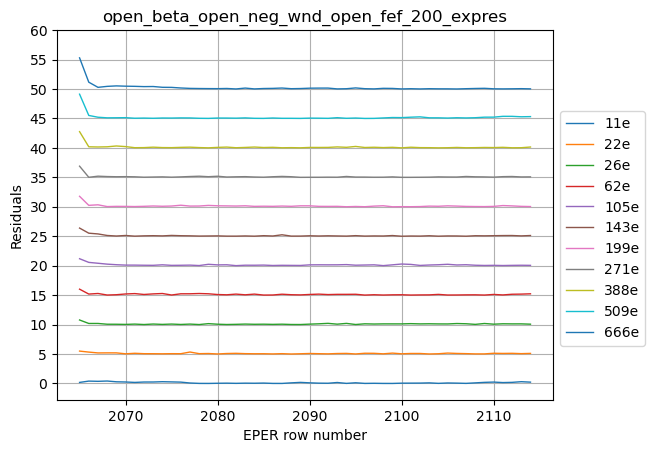

In [32]:
for i in range(len(data)):

    plot_residuals_with_offsets(
        data[i], target_profiles_all, phone_brightness_all, f"G/{subdir}/{filenames[i]}"
    )